In [1]:
# Python API Homework - Part I - WeatherPy
# UT-TOR-DATA-PT-01-2020-U-C Assignment #6
# (c) Boris Smirnov

# WeatherPy
----

In [2]:
%matplotlib notebook

In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Cities data from citipy module
input_data_file = '../Resources/worldcities.csv'

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Base OpenWeather URL
weather_url = f"https://api.openweathermap.org/data/2.5/weather?appid={weather_api_key}&units=metric"

In [4]:
# I'm not going to generate random coordinates and search for the nearest city.
# 71% of Earth's surface is covered by oceans. Theoretically, 71% of uniformely distributed random coordinates would
# be in the World Ocean, thus the nearest cities to that coordinates would be on the coast line, which definitely affects
# further analysis.
# I'm going to use worldcities.csv that came with citipy module and (almost) randomly pick cities from there.
# For that purpose, the first thing to do is to check cities distribution by parallels

cities_df = pd.read_csv(input_data_file)

# P.S.
# City name is a bad key: there are cities with the same name even in a single country
# More then 4000 cities have namesakes, that is significant 10% of the dataset
# Coordinates are better, especially when OpenWeather API allows query by coordinates, not only by (city,country)

# Total cities   Total unique city names by country                      Total unique city names worldwide
(len(cities_df), len(cities_df.groupby(by=['Country', 'City']).count()), len(cities_df['City'].unique()))

(46832, 43864, 42105)

In [5]:
# How cities are distributed by latitude?
latitude_bins = [lat for lat in range(-90, 100, 10)]
cities_df['Belt'] = pd.cut(cities_df['Latitude'], latitude_bins)
cities_df['Belt'].value_counts(sort=False)

(-90, -80]        0
(-80, -70]        0
(-70, -60]        0
(-60, -50]        3
(-50, -40]       91
(-40, -30]      448
(-30, -20]     1519
(-20, -10]     1119
(-10, 0]       1759
(0, 10]        3660
(10, 20]       6594
(20, 30]       3777
(30, 40]       5485
(40, 50]      13950
(50, 60]       7581
(60, 70]        816
(70, 80]         30
(80, 90]          0
Name: Belt, dtype: int64

In [6]:
# Redistribution of cities by "belts"
# I'll sample 50 cities per "belt", giving required >500 cities for further analysis
new_latitude_bins = [-90] + [lat for lat in range(-30, 70, 10)] + [90]
cities_df['Belt'] = pd.cut(cities_df['Latitude'], new_latitude_bins)
cities_df['Belt'].value_counts(sort=False)

(-90, -30]      542
(-30, -20]     1519
(-20, -10]     1119
(-10, 0]       1759
(0, 10]        3660
(10, 20]       6594
(20, 30]       3777
(30, 40]       5485
(40, 50]      13950
(50, 60]       7581
(60, 90]        846
Name: Belt, dtype: int64

In [7]:
# Check if we already have city weather data. If not, get it from OpenWeather. Otherwise, skip the next step
try:
    sample_cities_df = pd.read_csv(output_data_file) # no file -> exception
    if sample_cities_df.count() < 500:               # not enough data -> exception
        raise Exception("Not enough data.")
    belts = []                                       # already have data -> skip the for-loop below
    print(f"Weather data read from existing {output_data_file}. No data retrieval necessary")
except: # no or not enough data - initialize, and proceed to the for-loop below
    belts = cities_df['Belt'].unique()
    sample_cities_df = pd.DataFrame()

In [8]:
# Fill sample_cities_df DataFrame with sample cities data augmented with Weather data
for belt in belts:

    print(f"=== Retrieving data for cities in {belt} =============================================")
    
    # In case OpenWeather doesn't have info for a given location, I'll give 10% slack on try count
    tries_count = 0
    city_count = 0
    
    while (city_count < 50) & (tries_count < 55):
        sample_city = cities_df.loc[cities_df['Belt'] == belt].sample(1)
        city_idx = sample_city.index[0]
        city_dct = sample_city.iloc[0,:].to_dict()

        # Handle city collision: just try another one - there are plenty in every latitude belt
        if city_idx in sample_cities_df.index:
            continue
        else:
            tries_count +=1

        try:
            print(f"Latitudes:{belt}\tTry:{tries_count}/55\tCity:{city_count}/50\t{city_dct['Country']},{city_dct['City']}:\t\t", end='', flush=True)
                  
            time.sleep(1.1) # Limit: 60 requests per minute
                  
            query_url = weather_url + f"&lat={city_dct['Latitude']}&lon={city_dct['Longitude']}"
            response = requests.get(query_url)
            if response.status_code != 200:
                raise Exception(response.text)

            weather_data = response.json()
            city_dct['Date'] = weather_data['dt']
            city_dct['Max Temp'] = weather_data['main']['temp_max']
            city_dct['Wind Speed'] = weather_data['wind']['speed']
            city_dct['Cloudiness'] = weather_data['clouds']['all']
            city_dct['Humidity'] = weather_data['main']['humidity']
            # These two aren't actually necessary, since they are rounded up values of Latitude and Longitude from the request
            city_dct['Lon'] = weather_data['coord']['lon']
            city_dct['Lat'] = weather_data['coord']['lat']

            # Saving the result to the DataFrame
            sample_cities_df = sample_cities_df.append(pd.DataFrame([city_dct], index=[city_idx]))
            city_count += 1
            
            # Reporting
            print("Ok")

        except Exception as err:
            # If something went wrong, print the message and keep trying
            print(err)

    print(f"=== Done {belt} === {city_count} cities in {tries_count} tries ======================================================\n")


=== Retrieving data for cities in (40, 50] =============================================
Latitudes:(40, 50]	Try:1/55	City:0/50	cz,stramberk:		Ok
Latitudes:(40, 50]	Try:2/55	City:1/50	us,northbrook:		Ok
Latitudes:(40, 50]	Try:3/55	City:2/50	fr,manosque:		Ok
Latitudes:(40, 50]	Try:4/55	City:3/50	ca,georgetown:		Ok
Latitudes:(40, 50]	Try:5/55	City:4/50	hu,pecs:		Ok
Latitudes:(40, 50]	Try:6/55	City:5/50	ch,herisau:		Ok
Latitudes:(40, 50]	Try:7/55	City:6/50	at,grodig:		Ok
Latitudes:(40, 50]	Try:8/55	City:7/50	us,piqua:		Ok
Latitudes:(40, 50]	Try:9/55	City:8/50	ua,khorostkiv:		Ok
Latitudes:(40, 50]	Try:10/55	City:9/50	ru,poronaysk:		Ok
Latitudes:(40, 50]	Try:11/55	City:10/50	rs,josanicka banja:		Ok
Latitudes:(40, 50]	Try:12/55	City:11/50	us,detroit:		Ok
Latitudes:(40, 50]	Try:13/55	City:12/50	de,beckingen:		Ok
Latitudes:(40, 50]	Try:14/55	City:13/50	es,alcobendas:		Ok
Latitudes:(40, 50]	Try:15/55	City:14/50	ro,tatarastii de sus:		Ok
Latitudes:(40, 50]	Try:16/55	City:15/50	ro,buces:		Ok
Latit

Latitudes:(30, 40]	Try:36/55	City:35/50	us,huntsville:		Ok
Latitudes:(30, 40]	Try:37/55	City:36/50	us,blacklick estates:		Ok
Latitudes:(30, 40]	Try:38/55	City:37/50	il,dimona:		Ok
Latitudes:(30, 40]	Try:39/55	City:38/50	us,parlier:		Ok
Latitudes:(30, 40]	Try:40/55	City:39/50	us,marietta:		Ok
Latitudes:(30, 40]	Try:41/55	City:40/50	us,maywood:		Ok
Latitudes:(30, 40]	Try:42/55	City:41/50	il,kefar yona:		Ok
Latitudes:(30, 40]	Try:43/55	City:42/50	ir,azar shahr:		Ok
Latitudes:(30, 40]	Try:44/55	City:43/50	gr,kontokalion:		Ok
Latitudes:(30, 40]	Try:45/55	City:44/50	cn,ezhou:		Ok
Latitudes:(30, 40]	Try:46/55	City:45/50	gr,mitilini:		Ok
Latitudes:(30, 40]	Try:47/55	City:46/50	it,cagliari:		Ok
Latitudes:(30, 40]	Try:48/55	City:47/50	us,west puente valley:		Ok
Latitudes:(30, 40]	Try:49/55	City:48/50	us,hampton:		Ok
Latitudes:(30, 40]	Try:50/55	City:49/50	es,zafra:		Ok
=== Done (30, 40] === 50 cities in 50 tries ======================================================

=== Retrieving data for citi

Latitudes:(-10, 0]	Try:17/55	City:16/50	cg,ewo:		Ok
Latitudes:(-10, 0]	Try:18/55	City:17/50	br,toritama:		Ok
Latitudes:(-10, 0]	Try:19/55	City:18/50	br,sao domingos do maranhao:		Ok
Latitudes:(-10, 0]	Try:20/55	City:19/50	tz,mahonda:		Ok
Latitudes:(-10, 0]	Try:21/55	City:20/50	cg,loubomo:		Ok
Latitudes:(-10, 0]	Try:22/55	City:21/50	br,cajazeiras:		Ok
Latitudes:(-10, 0]	Try:23/55	City:22/50	br,quixada:		Ok
Latitudes:(-10, 0]	Try:24/55	City:23/50	br,pacajus:		Ok
Latitudes:(-10, 0]	Try:25/55	City:24/50	br,timon:		Ok
Latitudes:(-10, 0]	Try:26/55	City:25/50	br,igarape-miri:		Ok
Latitudes:(-10, 0]	Try:27/55	City:26/50	br,cachoeirinha:		Ok
Latitudes:(-10, 0]	Try:28/55	City:27/50	br,coelho neto:		Ok
Latitudes:(-10, 0]	Try:29/55	City:28/50	pe,san ignacio:		Ok
Latitudes:(-10, 0]	Try:30/55	City:29/50	br,nova cruz:		Ok
Latitudes:(-10, 0]	Try:31/55	City:30/50	br,arari:		Ok
Latitudes:(-10, 0]	Try:32/55	City:31/50	id,waingapu:		Ok
Latitudes:(-10, 0]	Try:33/55	City:32/50	tz,kamachumu:		Ok
Latitudes:(-

Latitudes:(-30, -20]	Try:50/55	City:49/50	br,loanda:		Ok
=== Done (-30, -20] === 50 cities in 50 tries ======================================================

=== Retrieving data for cities in (50, 60] =============================================
Latitudes:(50, 60]	Try:1/55	City:0/50	ru,tunoshna:		Ok
Latitudes:(50, 60]	Try:2/55	City:1/50	ru,khani:		Ok
Latitudes:(50, 60]	Try:3/55	City:2/50	dk,stenlille:		Ok
Latitudes:(50, 60]	Try:4/55	City:3/50	ru,karabanovo:		Ok
Latitudes:(50, 60]	Try:5/55	City:4/50	ee,maardu:		Ok
Latitudes:(50, 60]	Try:6/55	City:5/50	ru,mednogorsk:		Ok
Latitudes:(50, 60]	Try:7/55	City:6/50	dk,ribe:		Ok
Latitudes:(50, 60]	Try:8/55	City:7/50	ru,chernitsyno:		Ok
Latitudes:(50, 60]	Try:9/55	City:8/50	de,dannenberg:		Ok
Latitudes:(50, 60]	Try:10/55	City:9/50	ru,melekhovo:		Ok
Latitudes:(50, 60]	Try:11/55	City:10/50	dk,braedstrup:		Ok
Latitudes:(50, 60]	Try:12/55	City:11/50	nl,veere:		Ok
Latitudes:(50, 60]	Try:13/55	City:12/50	ru,togul:		Ok
Latitudes:(50, 60]	Try:14/55	Cit

Latitudes:(60, 90]	Try:35/55	City:34/50	no,stjordalshalsen:		Ok
Latitudes:(60, 90]	Try:36/55	City:35/50	se,ornskoldsvik:		Ok
Latitudes:(60, 90]	Try:37/55	City:36/50	no,sparbu:		Ok
Latitudes:(60, 90]	Try:38/55	City:37/50	gl,sisimiut:		Ok
Latitudes:(60, 90]	Try:39/55	City:38/50	ru,provideniya:		Ok
Latitudes:(60, 90]	Try:40/55	City:39/50	fi,eura:		Ok
Latitudes:(60, 90]	Try:41/55	City:40/50	us,sterling:		Ok
Latitudes:(60, 90]	Try:42/55	City:41/50	ru,nadym:		Ok
Latitudes:(60, 90]	Try:43/55	City:42/50	se,sundsvall:		Ok
Latitudes:(60, 90]	Try:44/55	City:43/50	ru,ilinskiy:		Ok
Latitudes:(60, 90]	Try:45/55	City:44/50	no,kvam:		Ok
Latitudes:(60, 90]	Try:46/55	City:45/50	is,vogar:		Ok
Latitudes:(60, 90]	Try:47/55	City:46/50	no,jessheim:		Ok
Latitudes:(60, 90]	Try:48/55	City:47/50	gb,scalloway:		Ok
Latitudes:(60, 90]	Try:49/55	City:48/50	no,sovik:		Ok
Latitudes:(60, 90]	Try:50/55	City:49/50	ru,revda:		Ok
=== Done (60, 90] === 50 cities in 50 tries ==================================================

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
# Saving data
if len(belts) > 0:
    sample_cities_df.to_csv(output_data_file, index=False)

In [10]:
print(f"Total sample cities: {len(sample_cities_df)}")
sample_cities_df

Total sample cities: 550


,Country,City,Latitude,Longitude,Belt,Date,Max Temp,Wind Speed,Cloudiness,Humidity,Lon,Lat
8298,cz,stramberk,49.590958,18.117846,"(40, 50]",1584020529,17.00,8.20,93,45,18.12,49.59
43336,us,northbrook,42.127500,-87.828889,"(40, 50]",1584020531,5.00,4.10,1,86,-87.83,42.13
11794,fr,manosque,43.832871,5.783948,"(40, 50]",1584020532,22.00,2.10,100,68,5.78,43.83
4627,ca,georgetown,43.650000,-79.933333,"(40, 50]",1584020533,2.22,5.70,75,80,-79.93,43.65
15901,hu,pecs,46.075363,18.232845,"(40, 50]",1584020534,20.00,3.60,85,37,18.23,46.08
...,...,...,...,...,...,...,...,...,...,...,...,...
20032,is,vogar,63.966667,-22.366667,"(60, 90]",1584021242,-1.00,4.10,75,68,-22.37,63.97
25894,no,jessheim,60.150000,11.183333,"(60, 90]",1584021243,7.78,2.60,98,38,11.18,60.15
12920,gb,scalloway,60.133333,-1.300000,"(60, 90]",1584021245,7.00,6.70,40,75,-1.30,60.13
26070,no,sovik,60.216111,5.387222,"(60, 90]",1584021246,5.56,6.20,75,80,5.39,60.22


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [11]:
date_str = time.strftime("%Y/%m/%d")

#### Latitude vs. Temperature Plot

<IPython.core.display.Javascript object>


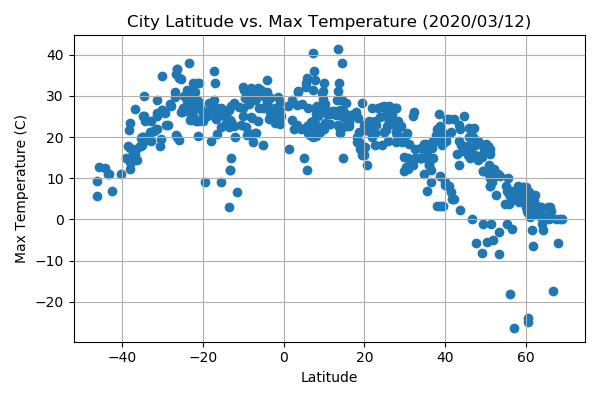

In [12]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Max Temperature ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Max Temp'])
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (C)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp.png')

The plot above demonstrates there might be some relationship between latitude and maximum temperature: the dots lay fairly compactly.  It also demonstrates raising temperatures when latitude approaches the equator, and dropping as latitudes reach their high abslute values. There is winter in Northern hemisphere, and you can see, that at high latitudes the temperatures fall significantly. On the other hand, there is summer in Southern hemisphere, and over there temeratures do drop, but not to such extent as in Nothern hemisphere.

#### Latitude vs. Humidity Plot

<IPython.core.display.Javascript object>


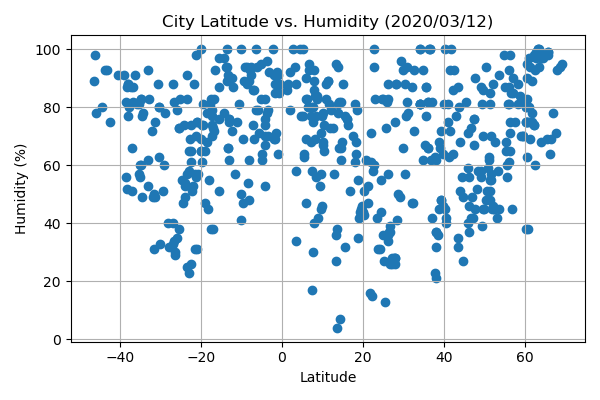

In [13]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Humidity ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Humidity'])
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity.png')

This chart demonstrates that Humidity doesn't probably depend on Latitude. We can see that Hummidity might take any value at any latitude. There are, obviously, other factors that affect it. 

#### Latitude vs. Cloudiness Plot

<IPython.core.display.Javascript object>


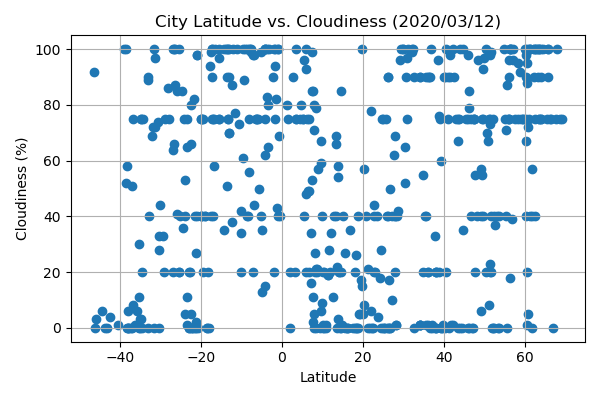

In [14]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Cloudiness ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Cloudiness'])
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness.png')

This chart demonstrates that Cloudiness doesn't probably depend on Latitude. We can see that Cloudiness might take any value at any latitude. The fact that dots are aligned along horizontal lines at 0%, 20%, 40% etc, might only indicate the low resolution and subjectiveness of measurement.

#### Latitude vs. Wind Speed Plot

<IPython.core.display.Javascript object>


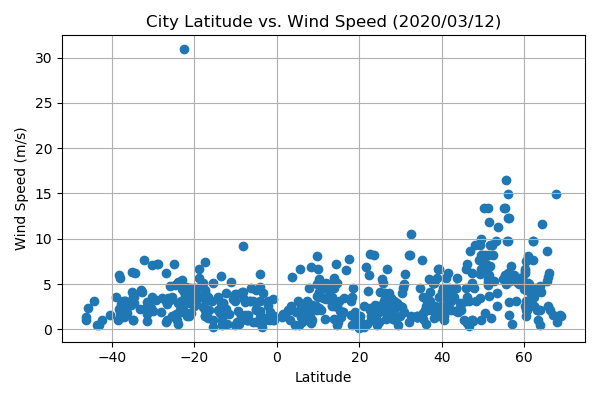

In [15]:
plt.figure(figsize=(6,4))

plt.title(f"City Latitude vs. Wind Speed ({date_str})")

plt.scatter(sample_cities_df['Lat'], sample_cities_df['Wind Speed'])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (m/s)')
plt.grid()

plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind.png')

The chart demonstrates the relation of Latitude and wind speed. If there is a trend here, it might be that winds at high latitudes in Northern hemesphere, where it's winter now, get stronger.

## Linear Regression

In [51]:
# OPTIONAL: Create a function to create Linear Regression plots
def plot_regression(df, y, y_label, annot_pos_x, annot_pos_y):

    x = 'Latitude'

    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
    print("The r-squared is: {:.4f}".format(rvalue))
    print("The p-value is: {:.8f}".format(pvalue))

    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y])
    plt.xlabel('Latitude')
    plt.ylabel(y_label)
    
    repress_points = [slope * point + intercept for point in df[x]]
    plt.plot(df[x], repress_points, "r-")

    line_eq = "y={:.2f}x{:+.2f}".format(slope, intercept)
    plt.annotate(line_eq, (annot_pos_x, annot_pos_y), fontsize=15, color="red")

    plt.grid()

In [52]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemisphere_df = sample_cities_df.loc[sample_cities_df['Latitude'] > 0, :]
southern_hemisphere_df = sample_cities_df.loc[sample_cities_df['Latitude'] < 0, :]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.8022
The p-value is: 0.00000000


<IPython.core.display.Javascript object>


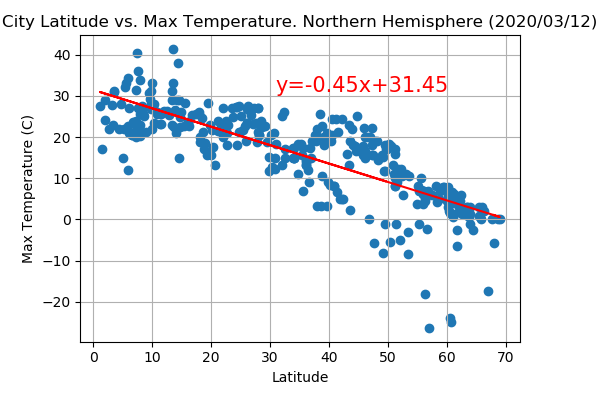

In [53]:
plot_regression(northern_hemisphere_df, 'Max Temp', 'Max Temperature (C)', 31, 31)
plt.title(f"City Latitude vs. Max Temperature. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp_north_regr.png')

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.4057
The p-value is: 0.00000000


<IPython.core.display.Javascript object>


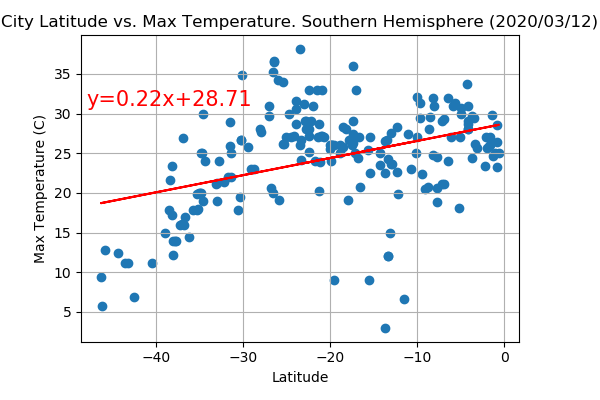

In [54]:
plot_regression(southern_hemisphere_df, 'Max Temp', 'Max Temperature (C)', -48, 31)
plt.title(f"City Latitude vs. Max Temperature. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_temp_south_regr.png')

####  Analysis: Northern vs. Southern Hemisphere - Max Temp vs. Latitude

There is winter in Northern hemisphere and the trend of temperature drop with latitude is very strong: $R^2$ is **0.8**, thus the linear model shows good prediction.

On the other hand, in Southern hemisphere:
* there is summer now
* there is much less land mass down there, which means the Ocean affects the climate more then in Northern hemisphere, making it more mild
* it's less polulated, and in the dataset there are only **200** data points vs. **350** data points for Northern hemisphere, meaning less data for analysis

Considering all of the above, the Temperature trend vs. Latitude is a lot less obvious for Southern hemisphere, then for Northern hemisphere. The **0.4** value of $R^2$ of linear regression model shows just that.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.1511
The p-value is: 0.00460784


<IPython.core.display.Javascript object>


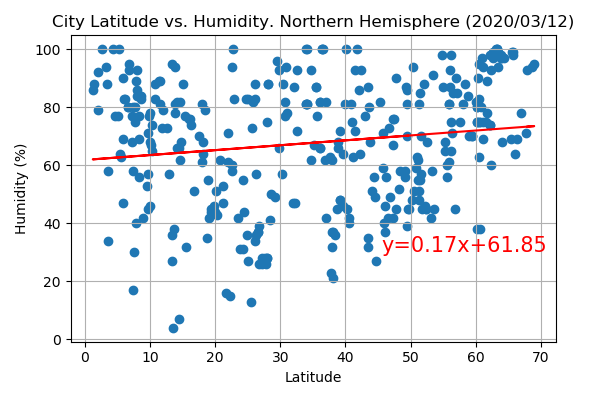

In [55]:
plot_regression(northern_hemisphere_df, 'Humidity', 'Humidity (%)', 45.5, 30)
plt.title(f"City Latitude vs. Humidity. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity_north_regr.png')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.1599
The p-value is: 0.02373534


<IPython.core.display.Javascript object>


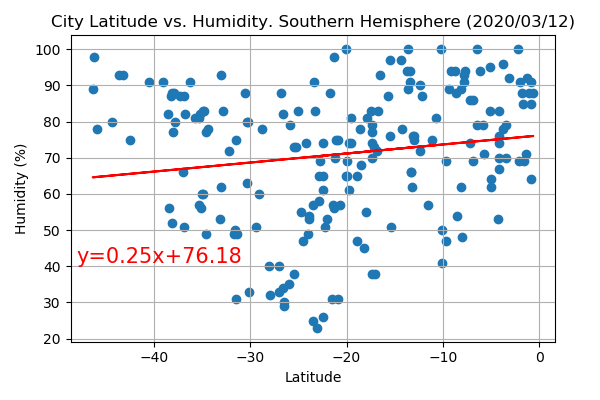

In [56]:
plot_regression(southern_hemisphere_df, 'Humidity', 'Humidity (%)', -48, 41)
plt.title(f"City Latitude vs. Humidity. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_humidity_south_regr.png')

####  Analysis: Northern vs. Southern Hemisphere - Humidity vs. Latitude

The charts demonstrate that Humidity isn't probably dependent on Latitude. Applying regressional analysis shows $R^2=0.15$ which proves there is no relationship. There are, obviously, other factors that affect humidity, such as big land mass (i.e. Eurasia in the North, and Australia in the South) that reduces the influence of the Ocean and decreases humidity.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.3484
The p-value is: 0.00000000


<IPython.core.display.Javascript object>


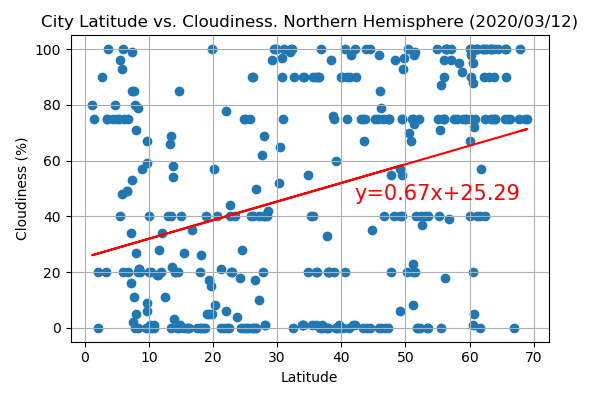

In [57]:
plot_regression(northern_hemisphere_df, 'Cloudiness', 'Cloudiness (%)', 42, 46)
plt.title(f"City Latitude vs. Cloudiness. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness_north_regr.png')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.4386
The p-value is: 0.00000000


<IPython.core.display.Javascript object>


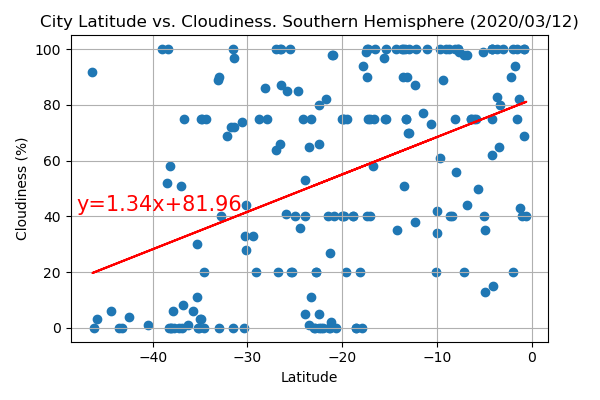

In [58]:
plot_regression(southern_hemisphere_df, 'Cloudiness', 'Cloudiness (%)', -48, 42)
plt.title(f"City Latitude vs. Cloudiness. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_cloudiness_south_regr.png')

####  Analysis: Northern vs. Southern Hemisphere - Cloudiness vs. Latitude

The charts demonstrate that Cloudiness doesn't probably dependent on Latitude. Applying regressional analysis shows $R^2$ around **0.4** for both hemispheres, which proves there is very weak relationship. There are, obviously, other factors that affect Cloudiness.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.3845
The p-value is: 0.00000000


<IPython.core.display.Javascript object>


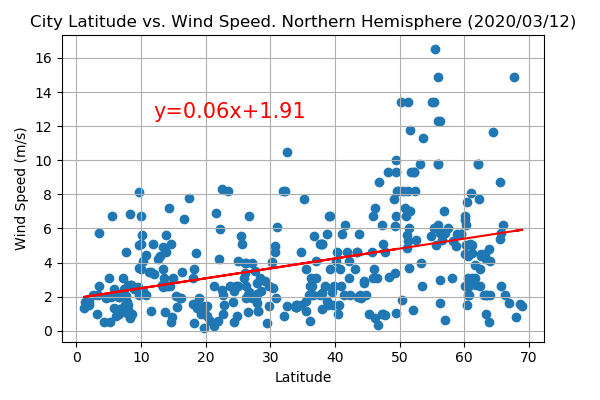

In [59]:
plot_regression(northern_hemisphere_df, 'Wind Speed', 'Wind Speed (m/s)', 12, 12.5)
plt.title(f"City Latitude vs. Wind Speed. Northern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind_north_regr.png')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.0991
The p-value is: 0.16284955


<IPython.core.display.Javascript object>


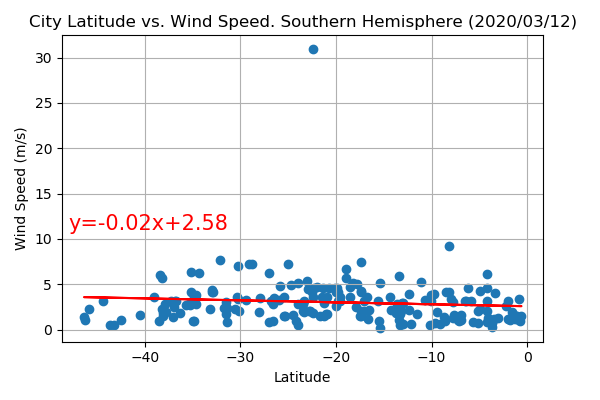

In [60]:
plot_regression(southern_hemisphere_df, 'Wind Speed', 'Wind Speed (m/s)', -48, 11)
plt.title(f"City Latitude vs. Wind Speed. Southern Hemisphere ({date_str})")
plt.show()
plt.tight_layout()
plt.savefig('../output_data/latitude_vs_wind_south_regr.png')

####  Analysis: Northern vs. Southern Hemisphere - Wind Speed vs. Latitude

The charts demonstrate that Wind speed doesn't probably dependent on Latitude. Applying regressional analysis shows $R^2$ around **0.4** for Northern hemisphere, and **-0.1** for Southern hemisphere. There might be a weak relation for the Northern part, but no trends is seen for the Southern.